In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import os
import PIL
from IPython.display import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Activation, Dense, BatchNormalization, Conv2D, MaxPool2D, AvgPool2D, GlobalAveragePooling2D, Dropout, Flatten, ReLU, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import confusion_matrix
from keras_visualizer import visualizer
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model
import tensorflow.keras.backend as K

import pathlib
import time
import datetime
import pickle
import random

os.environ['PYTHONHASHSEED']=str(123)
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

AttributeError: module 'keras.engine.base_layer' has no attribute 'BaseRandomLayer'

In [2]:
# Test to see whether you have all necessary libraries for GPU support
# If so, this should output a list with at least one GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

If a GPU is present, the next cell should be run to limit the amount of allocated memory on the GPU only to that which is necessary.

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Organizing the Data

In [4]:
train_dir = 'data/kaggle dataset/chest_xray/train'
test_dir = 'data/kaggle dataset/chest_xray/test'
val_dir = 'data/kaggle dataset/chest_xray/val'

In [5]:
train_norm_dir = os.path.join(train_dir, 'NORMAL')
train_pneu_dir = os.path.join(train_dir, 'PNEUMONIA')
val_norm_dir = os.path.join(val_dir, 'NORMAL')
val_pneu_dir = os.path.join(val_dir, 'PNEUMONIA')
test_norm_dir = os.path.join(test_dir, 'NORMAL')
test_pneu_dir = os.path.join(test_dir, 'PNEUMONIA')

In [6]:
len(os.listdir(train_norm_dir))

1221

In [7]:
def picture(filepath):
    filenames = os.listdir(filepath)
    filepaths = [os.path.join(filepath, name) for name in filenames]
    return [img for img in filepaths]

In [8]:
train_norm_images = picture(train_norm_dir)
train_pneu_images = picture(train_pneu_dir)

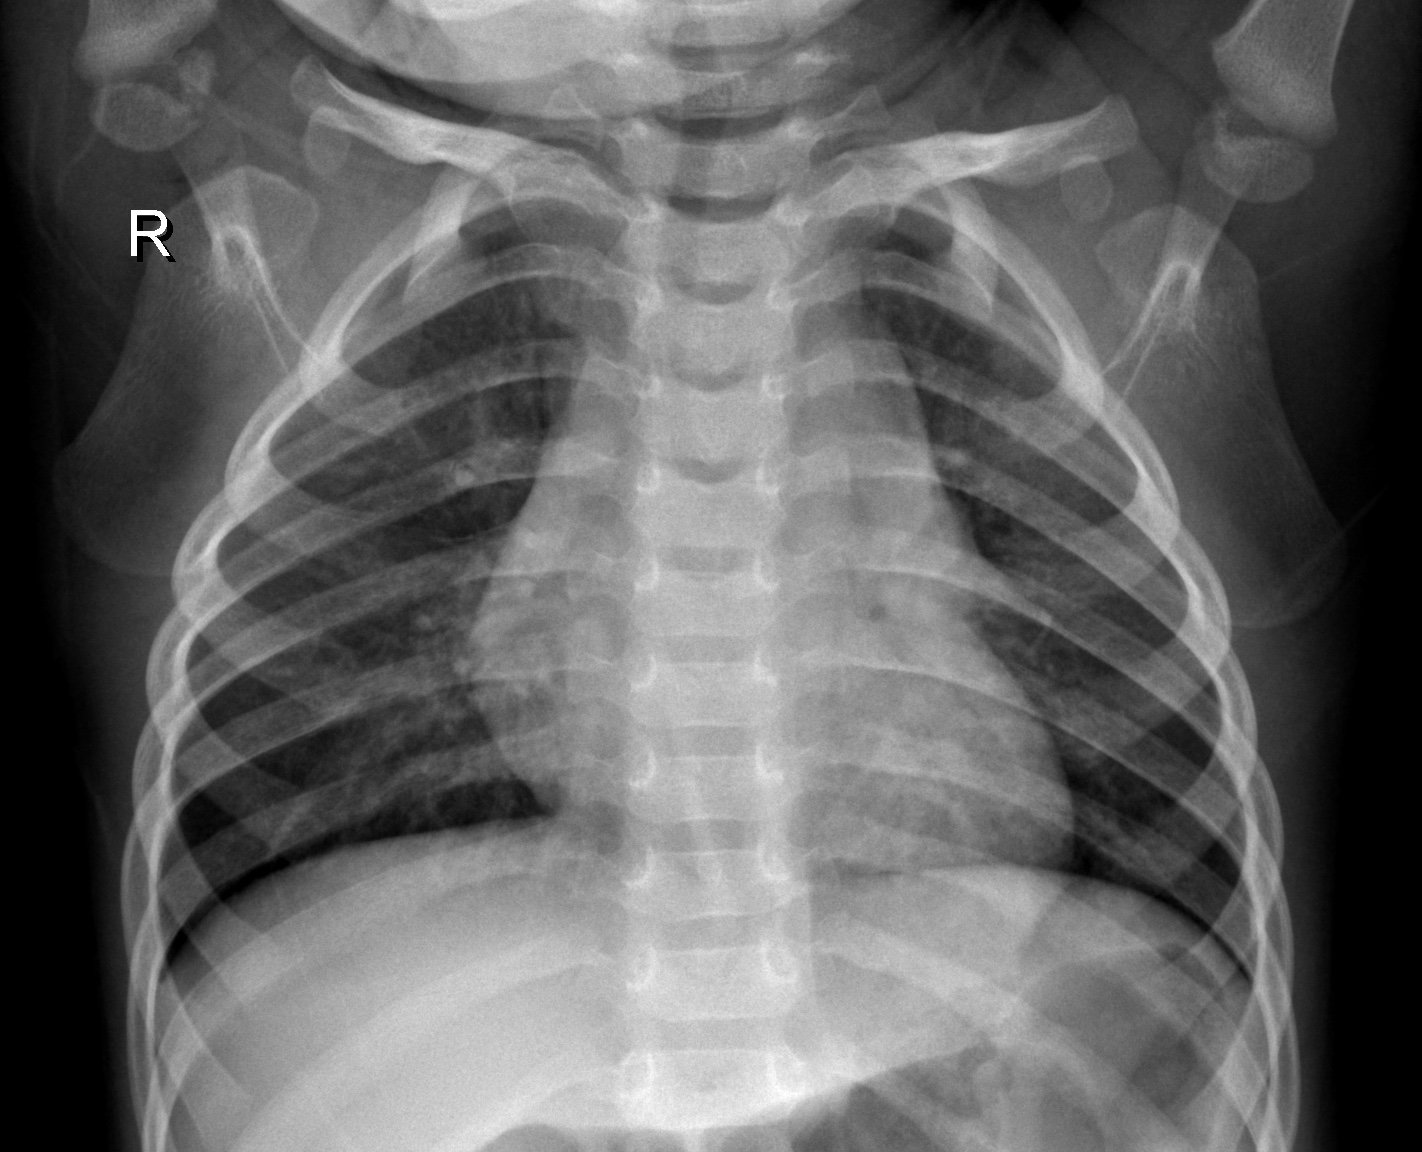

In [9]:
PIL.Image.open(train_norm_images[0])

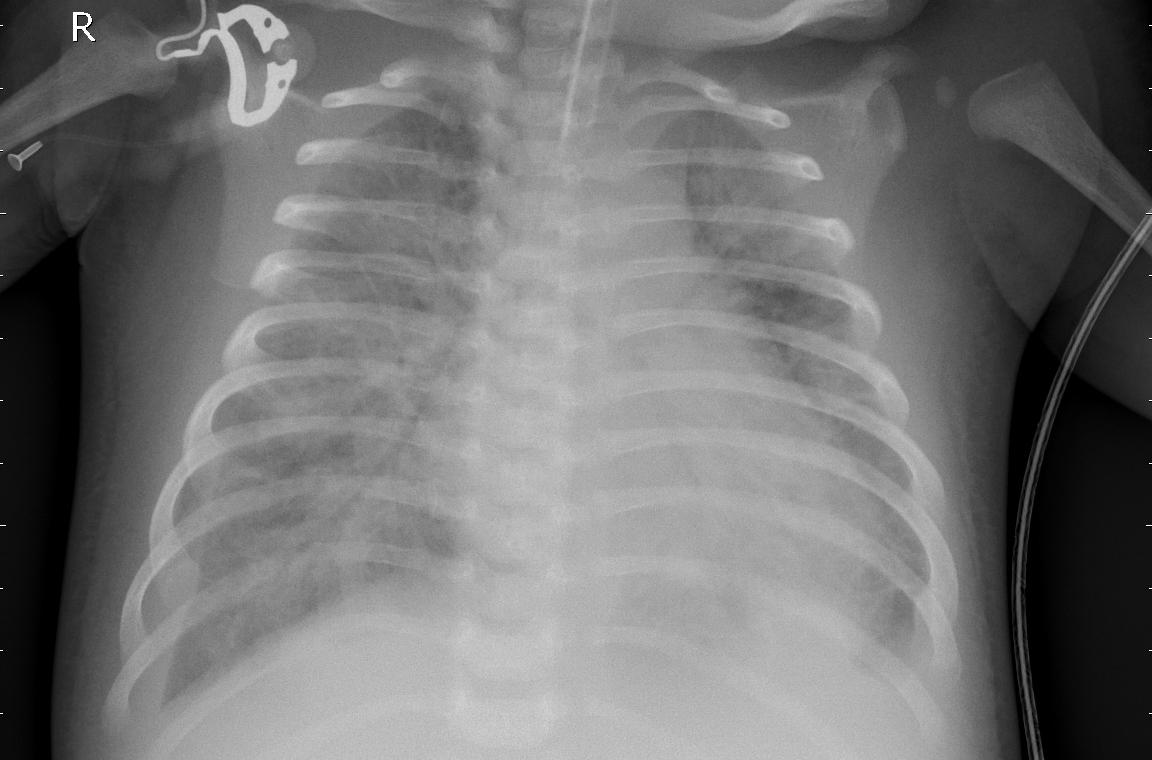

In [11]:
PIL.Image.open(train_pneu_images[0])

# Creating Test/Train Batches

In [10]:
# get all the data in the directory split/train (542 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255, 
                                     shear_range = 0.2, 
                                     zoom_range = 0.2, 
                                     width_shift_range=0.2,  
                                     height_shift_range=0.2, 
                                     rotation_range = 10
                                   ).flow_from_directory(train_dir,target_size=(256, 256), 
                                                         batch_size=4976,
                                                         class_mode='binary',
                                                         color_mode='grayscale')

# get all the data in the directory split/validation (200 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   width_shift_range=0.2,  
                                   height_shift_range=0.2, 
                                   rotation_range = 10
                                   ).flow_from_directory(val_dir,target_size=(256, 256), 
                                                         batch_size = 256,
                                                         class_mode='binary',
                                                         color_mode='grayscale')

# get all the data in the directory split/test (180 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255, 
                                    shear_range = 0.2, 
                                    zoom_range = 0.2, 
                                    width_shift_range=0.2,  
                                    height_shift_range=0.2, 
                                    rotation_range = 10
                                    ).flow_from_directory(test_dir,target_size=(256, 256), 
                                                          batch_size = 624,
                                                         class_mode='binary',
                                                         color_mode='grayscale') 


Found 4976 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
# create the data sets
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)


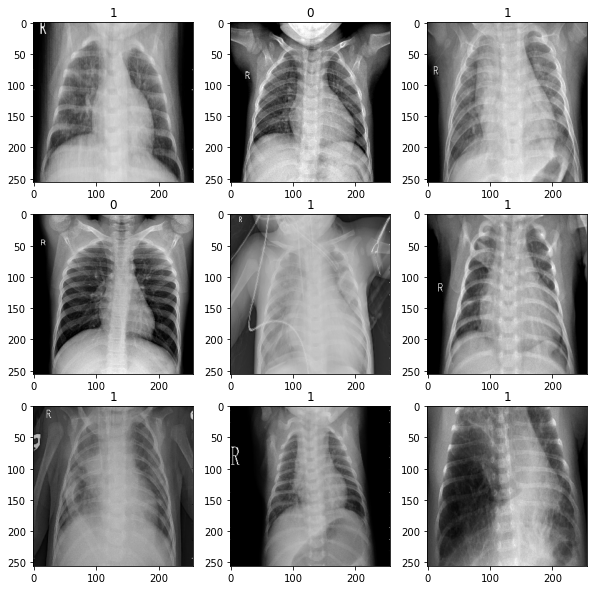

In [14]:
plt.figure(figsize=(10,10))

for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(array_to_img(train_images[i+250]))
    plt.title(int(train_labels[i+250][1]));

In [12]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 4976
Number of testing samples: 624
Number of validation samples: 256
train_images shape: (4976, 256, 256, 1)
train_labels shape: (4976,)
test_images shape: (624, 256, 256, 1)
test_labels shape: (624,)
val_images shape: (256, 256, 256, 1)
val_labels shape: (256,)


In [13]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(4976, 65536)
(624, 65536)
(256, 65536)


In [14]:
train_y = np.reshape(train_labels, (4976,1))
test_y = np.reshape(test_labels, (624,1))
val_y = np.reshape(val_labels, (256,1))

### DenseNet

CNN

In [15]:
filepath = 'best_model_cnn_hng.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

callbacks = [checkpoint, reduce_lr]

In [20]:
cnn_hng = models.Sequential()
cnn_hng.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
cnn_hng.add(layers.MaxPooling2D((2, 2)))
cnn_hng.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2=0.005)))
cnn_hng.add(layers.MaxPooling2D((2, 2)))
cnn_hng.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2=0.005)))
cnn_hng.add(layers.MaxPooling2D((2, 2)))
cnn_hng.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2=0.005)))
cnn_hng.add(layers.MaxPooling2D((2, 2)))
cnn_hng.add(layers.Flatten())
cnn_hng.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(l2=0.005)))
cnn_hng.add(layers.Dense(1, activation='sigmoid'))

adam = Adam(learning_rate=.001)
cnn_hng.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
history_cnn_hng = cnn_hng.fit(train_images,
                    train_y,
                    epochs=1000,
                    batch_size=32,
                    validation_data=(val_images, val_y),
                    callbacks=callbacks,
                    use_multiprocessing=True)

Epoch 1/1000
156/156 [==============================] - 11s 69ms/step - loss: 0.8736 - accuracy: 0.7653 - val_loss: 0.6062 - val_accuracy: 0.7734

Epoch 00001: val_loss improved from 0.75637 to 0.60618, saving model to best_model_cnn_hng.hdf5
Epoch 2/1000
156/156 [==============================] - 11s 68ms/step - loss: 0.4752 - accuracy: 0.7994 - val_loss: 0.5563 - val_accuracy: 0.8047

Epoch 00002: val_loss improved from 0.60618 to 0.55634, saving model to best_model_cnn_hng.hdf5
Epoch 3/1000
156/156 [==============================] - 11s 68ms/step - loss: 0.4186 - accuracy: 0.8330 - val_loss: 0.6152 - val_accuracy: 0.6211

Epoch 00003: val_loss did not improve from 0.55634
Epoch 4/1000
156/156 [==============================] - 11s 69ms/step - loss: 0.3648 - accuracy: 0.8708 - val_loss: 0.5400 - val_accuracy: 0.7695

Epoch 00004: val_loss improved from 0.55634 to 0.54004, saving model to best_model_cnn_hng.hdf5
Epoch 5/1000
156/156 [==============================] - 11s 69ms/step - l

In [22]:
results_test = cnn_hng.evaluate(test_images, test_y)

20/20 [==============================] - 1s 25ms/step - loss: 1.2905 - accuracy: 0.8205


In [23]:
cnn_hng.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 126, 126, 64)      18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 61, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 128)      

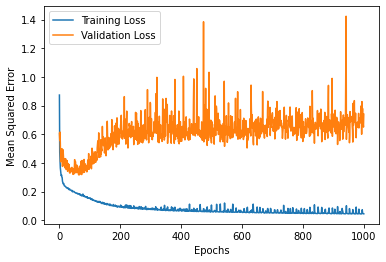

In [24]:
#plot the training history
plt.plot(history_cnn_hng.history['loss'], label='Training Loss')
plt.plot(history_cnn_hng.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.savefig('model_training_history')
plt.show()

In [28]:
load_file = 'best_model_cnn_hng.hdf5'

In [29]:
best_model_cnn_hng = load_model(load_file)

In [30]:
best_model_cnn_hng.evaluate(test_images, test_y)

20/20 [==============================] - 63s 26ms/step - loss: 0.5839 - accuracy: 0.8686


[0.5838893055915833, 0.8685897588729858]